# Import and description

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_boston
data_load = load_boston()

In [3]:
print(data_load.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
from sklearn.preprocessing import FunctionTransformer

data = pd.DataFrame(data_load['data'], columns=data_load['feature_names']) 
target = data_load['target']

category_col = ['B']
numeric_col = [col for col in data.columns.to_list() if col not in category_col]

def get_numeric_data_helper(x):
    return x[category_col]

def get_category_data_helper(x):
    return x[numeric_col]

get_numeric_data = FunctionTransformer(get_numeric_data_helper, validate=False)
get_category_data = FunctionTransformer(get_category_data_helper, validate=False)

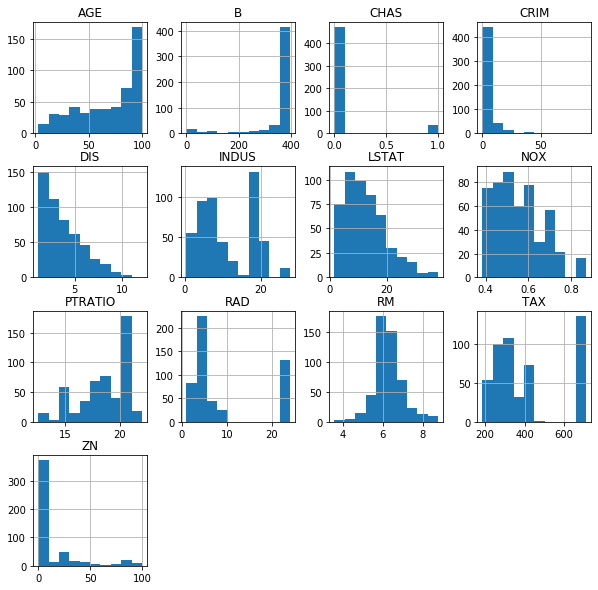

In [94]:
data.hist(figsize=(10, 10));

22.532806324110677 9.188011545278203


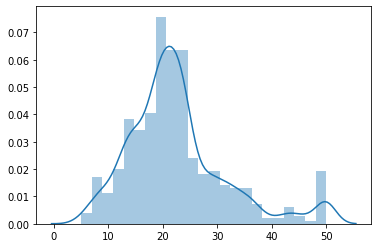

In [46]:
print(np.mean(target), np.std(target))
sns.distplot(target)

# Linear regression

In [115]:
# without tuning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

regression = LinearRegression()
score = cross_val_score(regression, data, target, scoring='neg_mean_absolute_error', cv=10)
print("-MAE: %.3f, (%.3f)" % (np.mean(score), np.std(score)))

-MAE: -4.005, (2.084)


In [16]:
# tuning
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import f_regression, SelectPercentile



feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])

model_pipe = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(score_func=f_regression)),
    ('linear_model', ElasticNet())
])

alpha = np.logspace(-2, 2, 5)
l1_ratio = np.arange(0, 1.1, 0.1)
percentile = np.arange(1, 22, 3)
params = {
    'linear_model__alpha': alpha,
    'linear_model__l1_ratio': l1_ratio,
    'featue_select__percentile': percentile
}

model_cv = GridSearchCV(model_pipe, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [17]:
model_cv.fit(data, target)
print(model_cv.best_params_)
print(model_cv.best_score_)

{'featue_select__percentile': 13, 'linear_model__alpha': 0.01, 'linear_model__l1_ratio': 1.0}
-3.436838196015799


C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4883.350324820806, tolerance: 4.2716295415019765
  positive)


# SVM

In [11]:
from sklearn.svm import SVR
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import f_regression, SelectPercentile

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])

model_pipe = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(score_func=f_regression)),
    ('svm', SVR())
])

C = np.logspace(-2, 2, 5)
tol = np.logspace(-4, -2, 3)
gamma = ['scale', 'auto']
epsilon = np.logspace(-2, 2, 5)
# kernel = ['linear', 'poly', 'rbf']
percentile = np.arange(1, 22, 3)

params = {
    'svm__C': C,
    'svm__tol': tol,
    'svm__gamma': gamma,
    'svm__epsilon': epsilon,
#     'svm__kernel': kernel,
    'featue_select__percentile': percentile
}

# model_cv = RandomizedSearchCV(model_pipe, param_distributions=params, scoring='neg_mean_absolute_error', cv=5,
#                               n_iter=50, n_jobs=-1)

model_cv = GridSearchCV(model_pipe, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
model_cv.fit(data, target)
print(model_cv.best_params_)
print(model_cv.best_score_)

{'featue_select__percentile': 10, 'svm__C': 100.0, 'svm__epsilon': 1.0, 'svm__gamma': 'scale', 'svm__tol': 0.001}
-4.072169888977014


# Random forest regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import f_regression, SelectPercentile

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
#         ('std', StandardScaler())      
    ]))
])

model_pipe = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(score_func=f_regression)),
    ('rfg', RandomForestRegressor(criterion='mae', n_jobs=-1))
])


n_estimators = [50, 100, 150, 200]
max_features = ['sqrt', 'log2', None]
# min_samples_split = [2, 4, 8, 16]
# min_samples_leaf = [1, 2, 4, 8]
min_impurity_decrease = np.arange(0, 0.05, 0.01)
percentile = np.arange(10, 23, 3)

params = {
    'rfg__n_estimators': n_estimators,
    'rfg__max_features': max_features,
#     'rfg__min_samples_split': min_samples_split,
#     'rfg__min_samples_leaf': min_samples_leaf,
    'rfg__min_impurity_decrease': min_impurity_decrease,
    'featue_select__percentile': percentile
}

# model_cv = RandomizedSearchCV(model_pipe, param_distributions=params, scoring='neg_mean_absolute_error', cv=5,
#                               n_iter=50, n_jobs=-1)

model_cv = GridSearchCV(model_pipe, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
model_cv.fit(data, target)
print(model_cv.best_params_)

print(model_cv.best_score_)

{'featue_select__percentile': 19, 'rfg__max_features': 'log2', 'rfg__min_impurity_decrease': 0.0, 'rfg__n_estimators': 100}
-3.0007387691710345


In [29]:
# from sklearn.externals import joblib
# joblib.dump(model_cv.best_estimator_, 'model/grid_search_rfg.pkl')

C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


PicklingError: Can't pickle <function <lambda> at 0x0000022138F18EA0>: it's not found as __main__.<lambda>

In [26]:
# Validate model on 10 fold cv
from sklearn.model_selection import cross_validate, StratifiedKFold

model_chosen = model_cv.best_estimator_
kfold = StratifiedKFold(n_splits=10, shuffle=True)

scoring = {'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error'
          }

cv_result = cross_validate(model_chosen, data, target, scoring=scoring, cv=10)

C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


KeyError: 'mae'

In [28]:
mae = cv_result['test_mae']
mse = cv_result['test_mse']
print("-MAE: %.3f, (%.3f)" % (np.mean(mae), np.std(mae)))
print("-MSE: %.3f, (%.3f)" % (np.mean(mse), np.std(mse)))

-MAE: -2.990, (1.062)
-MSE: -19.670, (19.843)


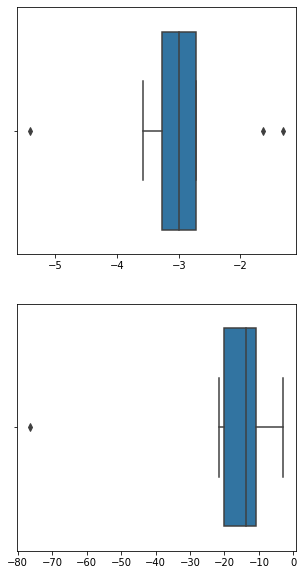

In [42]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=False)

sns.boxplot(mae,  ax=axes[0]);
sns.boxplot(mse,  ax=axes[1]);

# Gradient Boosting

C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Amo.CH.Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


-3.0403194274431145


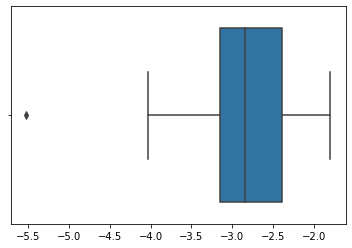

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])


model_pipe = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('interaction', PolynomialFeatures(interaction_only=True, include_bias=False)), 
    ('featue_select', SelectPercentile(percentile=20, score_func=f_regression)),
    ('gbr', GradientBoostingRegressor())
])

kfold = StratifiedKFold(n_splits=10, shuffle=True)
cv_result = cross_validate(model_pipe, data, target, scoring='neg_mean_absolute_error', cv=10)
print(np.mean(cv_result['test_score']))
sns.boxplot(cv_result['test_score']);

# Neural Network

In [120]:
from keras.layers import Dense
from keras import Sequential
from keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import EarlyStopping

def build_nn_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(data.shape[1], )))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam()
    
    model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])
    return model

In [132]:
nn_model = build_nn_model()
nn_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [133]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

feature_preprocessing = FeatureUnion([
    ('category_data', get_category_data),
    ('numeric_data', Pipeline([
        ('get_numeric_data', get_numeric_data),
        ('std', StandardScaler())      
    ]))
])

X = feature_preprocessing.fit_transform(data)

In [134]:
early_stop = EarlyStopping(patience=30, restore_best_weights=True)

history = nn_model.fit(X,
                       target,
                       batch_size=1,
                       epochs=200,
                       validation_split=0.1,
                       verbose=2,
                       callbacks=[early_stop]
                      )

Train on 455 samples, validate on 51 samples
Epoch 1/200
 - 1s - loss: 9.6661 - mae: 10.1514 - val_loss: 5.7581 - val_mae: 6.2458
Epoch 2/200
 - 1s - loss: 7.1642 - mae: 7.6494 - val_loss: 5.0113 - val_mae: 5.5029
Epoch 3/200
 - 1s - loss: 6.5166 - mae: 7.0003 - val_loss: 6.2269 - val_mae: 6.7234
Epoch 4/200
 - 1s - loss: 6.3040 - mae: 6.7892 - val_loss: 4.0602 - val_mae: 4.5392
Epoch 5/200
 - 1s - loss: 5.1570 - mae: 5.6303 - val_loss: 3.6814 - val_mae: 4.1636
Epoch 6/200
 - 1s - loss: 5.1936 - mae: 5.6715 - val_loss: 4.1075 - val_mae: 4.5740
Epoch 7/200
 - 1s - loss: 4.6480 - mae: 5.1262 - val_loss: 7.3436 - val_mae: 7.8379
Epoch 8/200
 - 1s - loss: 4.8075 - mae: 5.2845 - val_loss: 4.0129 - val_mae: 4.4836
Epoch 9/200
 - 1s - loss: 4.5769 - mae: 5.0465 - val_loss: 7.9744 - val_mae: 8.4636
Epoch 10/200
 - 1s - loss: 4.6344 - mae: 5.1149 - val_loss: 3.6785 - val_mae: 4.1360
Epoch 11/200
 - 1s - loss: 4.3770 - mae: 4.8441 - val_loss: 4.6680 - val_mae: 5.1430
Epoch 12/200
 - 1s - loss: 4

Epoch 97/200
 - 1s - loss: 2.0512 - mae: 2.4981 - val_loss: 2.5314 - val_mae: 2.9860
Epoch 98/200
 - 1s - loss: 2.1201 - mae: 2.5619 - val_loss: 2.6795 - val_mae: 3.1473
Epoch 99/200
 - 1s - loss: 1.9209 - mae: 2.3587 - val_loss: 2.6234 - val_mae: 3.0685
Epoch 100/200
 - 1s - loss: 2.0144 - mae: 2.4642 - val_loss: 2.6059 - val_mae: 3.0622
Epoch 101/200
 - 1s - loss: 1.9072 - mae: 2.3446 - val_loss: 2.8349 - val_mae: 3.3081
Epoch 102/200
 - 1s - loss: 1.9882 - mae: 2.4307 - val_loss: 2.3324 - val_mae: 2.7668
Epoch 103/200
 - 1s - loss: 2.0229 - mae: 2.4734 - val_loss: 2.6616 - val_mae: 3.1296
Epoch 104/200
 - 1s - loss: 2.0173 - mae: 2.4588 - val_loss: 2.7881 - val_mae: 3.2608
Epoch 105/200
 - 1s - loss: 2.0535 - mae: 2.5119 - val_loss: 2.4849 - val_mae: 2.9127
Epoch 106/200
 - 1s - loss: 2.0379 - mae: 2.4892 - val_loss: 2.6492 - val_mae: 3.0995
Epoch 107/200
 - 1s - loss: 2.0243 - mae: 2.4665 - val_loss: 2.4956 - val_mae: 2.9613
Epoch 108/200
 - 1s - loss: 2.0175 - mae: 2.4717 - val_lo

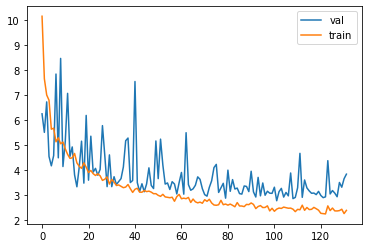

In [135]:
import matplotlib.pyplot as plt

val_mae = history.history['val_mae']
train_mae = history.history['mae']

plt.plot(val_mae)
plt.plot(train_mae)
plt.legend(['val', 'train']);

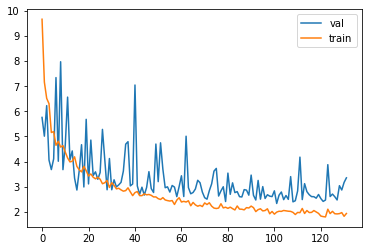

In [136]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']

plt.plot(val_loss)
plt.plot(train_loss)
plt.legend(['val', 'train']);

In [142]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

k_fold = KFold(10)

MAE = []
for trn_idx, val_idx in k_fold.split(data):
#     X_train, X_test = data.iloc[trn_idx,:], target[val_idx]
    y_train, y_test =  data.iloc[val_idx,:], target[val_idx]
    
    y_train = feature_preprocessing.transform(y_train)
    
    pred = nn_model.predict(y_train)
    MAE.append(mean_absolute_error(y_test, pred)) 
    
print(MAE)
print(np.mean(MAE), np.std(MAE))

[1.5519512064316694, 1.5225857379389747, 1.1703393412571328, 2.417099597407322, 2.2105260437610106, 1.9128464717490994, 1.4602115325927736, 4.123262384414674, 2.2356808395385745, 2.8145687484741213]
2.141907190356535 0.8161007213838329
